In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
import tf_keras
from tf_keras.layers import Dense, Dropout

from sklearn.preprocessing import StandardScaler

from data_frame import DataFrame, MaxFiller

import matplotlib.pyplot as plt
from plotting_functions import plotTrainHistory

tfd = tfp.distributions

filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

In [4]:
df = DataFrame(filePath, "QSO", filler=MaxFiller())
X_train, y_train = df.get_train_dataset()
X_val, y_val = df.get_val_dataset()

In [5]:
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_val = scaler_x.transform(X_val)

Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 24.


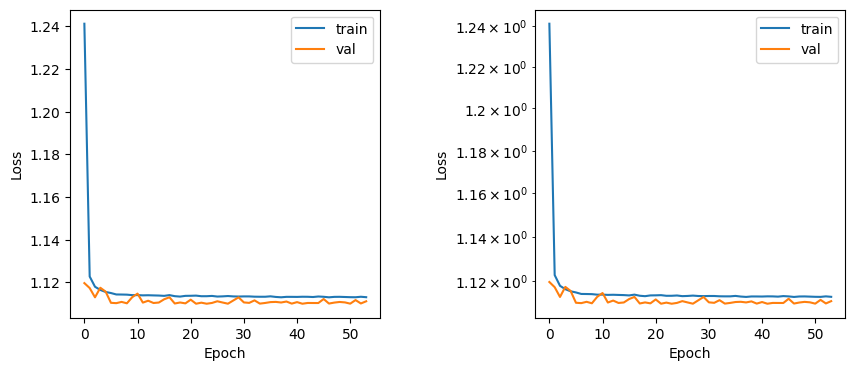

In [71]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

model = tf_keras.Sequential([Dense(256, kernel_initializer='normal', activation='relu', input_shape=(55,)),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(256, kernel_initializer='normal', activation='relu'),
                             Dense(4),
                             tfp.layers.DistributionLambda(lambda t: tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=[0.5,0.5]),
                                                                                            components_distribution=tfd.Normal(loc=t[...,:2],
                                                                                                                               scale=1e-3 + tf.nn.softplus(0.05 * t[..., 2:4]))))],
                            name = "double_gaussian_output")

model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.0001), loss=negloglik)

callback = tf_keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                            patience=30, verbose=1, 
                                            start_from_epoch=1, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=128,
                    epochs=1000, verbose=0, callbacks=callback)
plotTrainHistory(history)

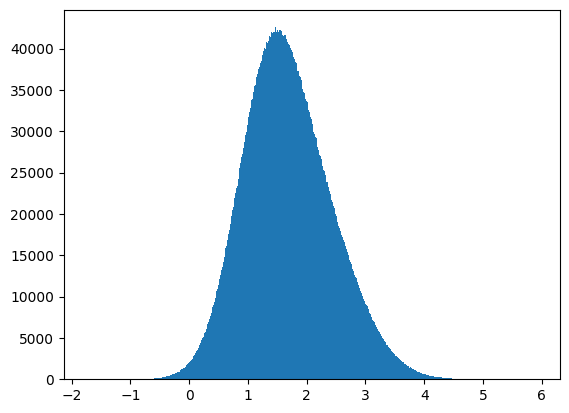

In [77]:
x = 1
y_model = model(X_val[x:x+1])
y_pred = y_model.sample(10000000).numpy()
plt.hist(y_pred, bins=1000)
plt.show()

In [78]:
samples = y_model.sample(10000)
y_pred = np.median(samples)
lower = np.percentile(samples, 5)
upper = np.percentile(samples, 95)
uncertainty = (upper - lower) / 2
print(f"True value {y_val.values[x]}")
print(f"Predicted value {y_pred:.3f} +/ {uncertainty:.3f}")

True value 1.793130359398586
Predicted value 1.627 +/ 1.218


In [73]:
y_model.mean(), y_model.stddev()

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.7225668], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.75017506], dtype=float32)>)

In [15]:
type(y_pred)

numpy.ndarray

In [76]:
means = y_model.components_distribution.loc.numpy()
stds = y_model.components_distribution.scale.numpy() 
means, stds

(array([[1.3208418, 2.0414095]], dtype=float32),
 array([[0.5509575 , 0.74181753]], dtype=float32))